In [1]:
from typing import List, Union
import numpy as np
from tqdm import tqdm

import diffusers
import torch
from torchvision import transforms
from PIL import Image

from src import helpers

PyTorch version: 2.0.1+cu117


# Step by Step - Image Variation

The `diffusers.StableDiffusionImageVariationPipeline.__call__` function broken down into steps.

References:
- https://huggingface.co/lambdalabs/sd-image-variations-diffusers
- https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_image_variation.py

In [2]:
model_id = "lambdalabs/sd-image-variations-diffusers"

device = "cuda:1" if torch.cuda.is_available() else "cpu"
dtype = torch.float16

pipe = diffusers.StableDiffusionImageVariationPipeline.from_pretrained(
    model_id,
    torch_dtype=dtype,
    revision="v2.0",
).to(device)

pipe.scheduler = diffusers.UniPCMultistepScheduler.from_config(pipe.scheduler.config)

print(pipe)
print("Device:", pipe.device)

image_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionImageVariationPipeline {
  "_class_name": "StableDiffusionImageVariationPipeline",
  "_diffusers_version": "0.20.2",
  "_name_or_path": "lambdalabs/sd-image-variations-diffusers",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Device: cuda:1


## Input Parameters

(512, 512)


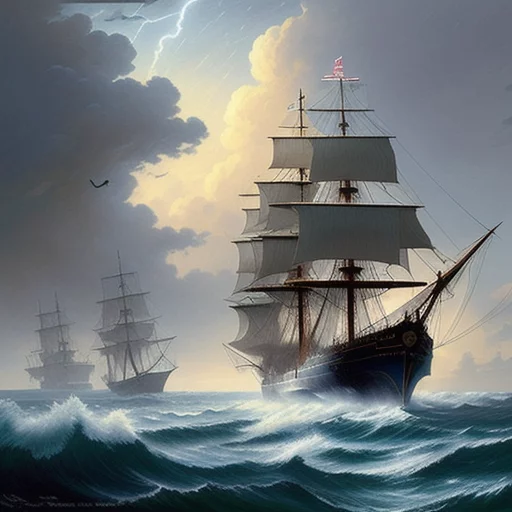

In [3]:
# Guidance-related
image_in = diffusers.utils.load_image(
    "https://stablediffusion.fr/assets/seascape/2-painting,%20science%20fiction,%20fran%C3%A7ois%20balanger%20style,%20high%20seas,%20antique%20sailing%20ship,%20storm,%20storm%20light,%20spaceship,%20birds.webp"
)
print(image_in.size)

# here `guidance_scale` is defined analog to the guidance weight `w` of equation (2) of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf .
# `guidance_scale = 1` corresponds to doing no classifier free guidance.
guidance_scale: float = 4.0

num_inference_steps: int = 50
num_images_per_prompt: int = 5

image_in

## Process the Input Image

In the pipeline, a PIL Image is processed into a torch.Tensor using `pipe.feature_extractor` (`CLIPImageProcessor`)
- CLIPImageProcessor: https://huggingface.co/docs/transformers/v4.33.0/en/model_doc/clip#transformers.CLIPImageProcessor

However, as the authors of this model checkpoint [note](https://huggingface.co/lambdalabs/sd-image-variations-diffusers#the-importance-of-resizing-correctly-or-not), 
there was an oversight during training, and the model expects resized images without anti-aliasing.

Therefore we utilize their sample code for the transform to resize without anti-aliasing and normalize.

In [4]:
tform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            (224, 224),
            interpolation=transforms.InterpolationMode.BICUBIC,
            antialias=False,
        ),
        transforms.Normalize(
            [0.48145466, 0.4578275, 0.40821073],
            [0.26862954, 0.26130258, 0.27577711],
        ),
    ]
)
image_processed = tform(image_in).to(device).unsqueeze(0)

# If a PIL image is passed, it will be processed with the pipeline's feature extractor
if not isinstance(image_in, torch.Tensor):
    image_processed = pipe.feature_extractor(
        images=image_in,
        return_tensors="pt",
    ).pixel_values
    
    image_processed = image_processed.to(
        device=device,
        dtype=dtype,
    )

print(image_processed.shape)
print("min:", image_processed.min())
print("max:", image_processed.max())

torch.Size([1, 3, 224, 224])
min: tensor(-1.7627, device='cuda:1', dtype=torch.float16)
max: tensor(2.0898, device='cuda:1', dtype=torch.float16)


## Encode the Input Image

References:
- CLIP: https://huggingface.co/docs/transformers/model_doc/clip
- CLIPVisionModelWithProjection: https://huggingface.co/docs/transformers/v4.33.0/en/model_doc/clip#transformers.CLIPVisionModelWithProjection

In [5]:
# image_encoder is a CLIPVisionModelWithProjection (Frozen CLIP image-encoder ([clip-vit-large-patch14])
clip_vision_model_output = pipe.image_encoder(image_processed)
print("clip_vision_model_output:", clip_vision_model_output.keys())
image_embeds = clip_vision_model_output.image_embeds
image_embeds = image_embeds.unsqueeze(1)
print("image_embeds.shape:", image_embeds.shape)

# duplicate image embeddings for each generation per prompt, using mps friendly method
bs_embed, seq_len, _ = image_embeds.shape
image_embeds = image_embeds.repeat(1, num_images_per_prompt, 1)
image_embeds = image_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)
print("image_embeds.shape:", image_embeds.shape)

# here `guidance_scale` is defined analog to the guidance weight `w` of equation (2) of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf .
# `guidance_scale = 1` corresponds to doing no classifier free guidance.
do_classifier_free_guidance = guidance_scale > 1.0

# For classifier free guidance, we normally need to do two forward passes.
# To avoid doing two forward passes, we concatenate the unconditional and text embeddings into a single batch
if do_classifier_free_guidance:
    negative_prompt_embeds = torch.zeros_like(image_embeds)
    image_embeds = torch.cat([negative_prompt_embeds, image_embeds])

print("image_embeds.shape:", image_embeds.shape)

clip_vision_model_output: odict_keys(['image_embeds', 'last_hidden_state'])
image_embeds.shape: torch.Size([1, 1, 768])
image_embeds.shape: torch.Size([5, 1, 768])
image_embeds.shape: torch.Size([10, 1, 768])


## Generating the initial latents

Our latents start out as random noise.

In [6]:
latent_shape = (
    num_images_per_prompt,
    pipe.unet.config.in_channels,
    image_in.height // pipe.vae_scale_factor,
    image_in.width // pipe.vae_scale_factor,
)
print("latents_shape:", latent_shape)

# random noise tensor
random_latents = diffusers.utils.randn_tensor(
    latent_shape,
    generator=None,
    device=pipe.device,
    dtype=dtype,
)

# scale the initial noise by the standard deviation required by the scheduler
print("pipe.scheduler.init_noise_sigma:", pipe.scheduler.init_noise_sigma)
random_latents = random_latents * pipe.scheduler.init_noise_sigma

latents_shape: (5, 4, 64, 64)
pipe.scheduler.init_noise_sigma: 1.0


## Defining the Denoising Loop


In [7]:
@torch.no_grad()
def denoising_loop(latents, timesteps):
    print("timesteps:", timesteps, "| len:", len(timesteps))
    for i, tstep in tqdm(enumerate(timesteps)):
        # expand the latents if we are doing classifier free guidance
        if do_classifier_free_guidance:
            latent_model_input = torch.cat([latents] * 2)
        else:
            latent_model_input = latents

        # scale the latent model input by the current noise schedule
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, tstep)

        # predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input,
            tstep,
            encoder_hidden_states=image_embeds,
        ).sample

        # perform classifier-free guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (
                noise_pred_text - noise_pred_uncond
            )

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, tstep, latents).prev_sample

    # decode the final latents to get the final image
    image_out = pipe.vae.decode(
        latents / pipe.vae.config.scaling_factor,
        return_dict=False,
    )[0]
    print("image_out.shape:", image_out.shape)

    # postprocess the image(s) (denormalize, convert to PIL, etc.)
    image_out = pipe.image_processor.postprocess(
        image_out,
        output_type="pil",
        do_denormalize=[True] * image_out.shape[0],
    )
    return image_out

## Run the Denoising Loop

timesteps: tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180,
        160, 140, 120, 100,  80,  60,  40,  20], device='cuda:1') | len: 50


50it [00:18,  2.76it/s]


image_out.shape: torch.Size([5, 3, 512, 512])


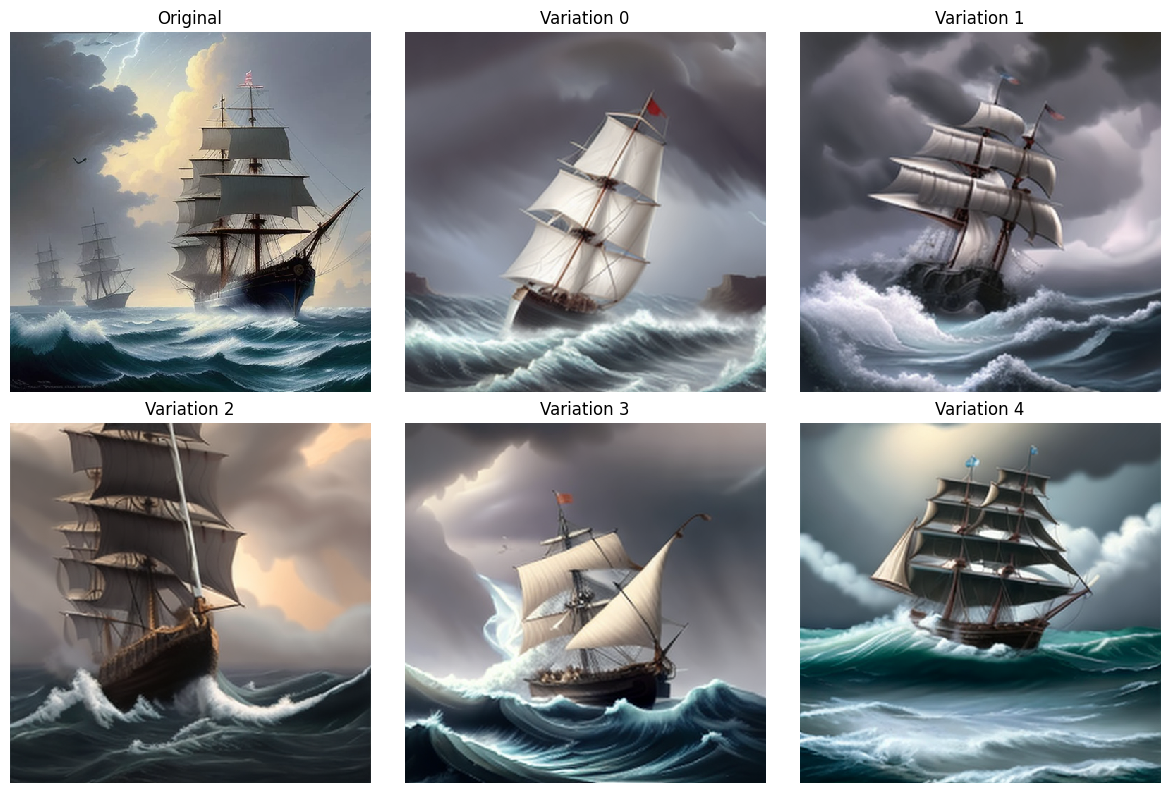

In [8]:
# Set up the scheduler
pipe.scheduler.set_timesteps(
    num_inference_steps,
    device=pipe.device,
)

# Run the denoising loop
image_out = denoising_loop(
    latents=random_latents,
    timesteps=pipe.scheduler.timesteps,
)

# Plot the results
helpers.plot(
    [image_in, *image_out],
    captions=["Original", *[f"Variation {i}" for i in range(len(image_out))]],
)

## Generating Closer Variations

In [9]:
def preprocess(image: Union[Image.Image, List[Image.Image]]):
    if isinstance(image, Image.Image):
        image = [image]

    # resize to integer multiple of 8
    w, h = image[0].size
    w, h = map(lambda x: x - x % 8, (w, h))

    # create batch
    image = [np.array(i.resize((w, h), resample=Image.LANCZOS))[None, :] for i in image]
    image_np = np.concatenate(image, axis=0).astype(np.float32)

    # normalize to [-1.0, 1.0]
    image_np = image_np / 255.0
    image_np = 2.0 * image_np - 1.0

    # convert to NCHW
    image_np = image_np.transpose(0, 3, 1, 2)
    return torch.from_numpy(image_np)

@torch.no_grad()
def decode_latents(latents):
    image_out = pipe.vae.decode(
        latents / pipe.vae.config.scaling_factor,
        return_dict=False,
    )[0]
    print("image_out.shape:", image_out.shape)

    # postprocess the image(s) (denormalize, convert to PIL, etc.)
    image_out = pipe.image_processor.postprocess(
        image_out,
        output_type="pil",
        do_denormalize=[True] * image_out.shape[0],
    )
    return image_out

processed_image.shape: torch.Size([1, 3, 512, 512])
min: tensor(-1., device='cuda:1', dtype=torch.float16)
max: tensor(1., device='cuda:1', dtype=torch.float16)
image_latents.shape: torch.Size([5, 4, 64, 64])
timesteps: tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180,
        160, 140, 120, 100,  80,  60,  40,  20], device='cuda:1') len(timesteps): 50
start_timestep: tensor(599, device='cuda:1')
timesteps_remaining: tensor([599, 579, 559, 539, 519, 500, 480, 460, 440, 420, 400, 380, 360, 340,
        320, 300, 280, 260, 240, 220, 200, 180, 160, 140, 120, 100,  80,  60,
         40,  20], device='cuda:1')
init_latent.shape: torch.Size([5, 4, 64, 64])
image_out.shape: torch.Size([5, 3, 512, 512])


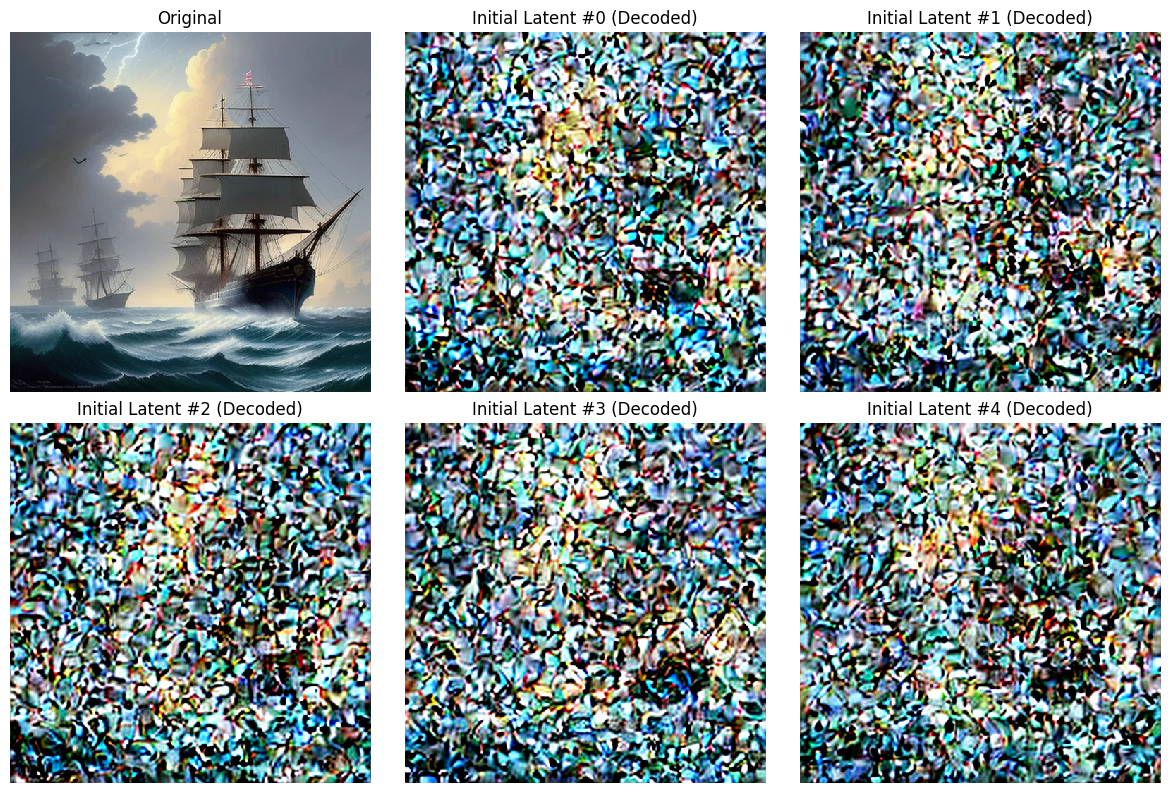

In [14]:
start_step = 20

# ==================================================================================================
image_processed_scaled = preprocess(image_in).to(device=device, dtype=dtype)
print("processed_image.shape:", image_processed_scaled.shape)
print("min:", image_processed_scaled.min())
print("max:", image_processed_scaled.max())

# Use the VAE Encoder to get the initial latents by sampling from the distribution
image_latents = pipe.vae.encode(image_processed_scaled).latent_dist.sample()
# scale the latents by the scaling factor required by the VAE
image_latents = pipe.vae.config.scaling_factor * image_latents
# duplicate latents for each generation per prompt, using mps friendly method
image_latents = torch.cat([image_latents] * num_images_per_prompt, dim=0)
print("image_latents.shape:", image_latents.shape)

# ==================================================================================================
# Set up the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps
print("timesteps:", timesteps, "len(timesteps):", len(timesteps))
start_timestep = timesteps[start_step]
print("start_timestep:", start_timestep)
timesteps_remaining = timesteps[start_step:]
print("timesteps_remaining:", timesteps_remaining)

# Add noise to the image latents to advance to the new starting timestep
noise = diffusers.utils.randn_tensor(
    image_latents.shape, generator=None, device=device, dtype=dtype
)
init_latents = pipe.scheduler.add_noise(
    image_latents,
    noise,
    start_timestep.repeat(num_images_per_prompt),
)
init_latents = init_latents * pipe.scheduler.init_noise_sigma
print("init_latent.shape:", image_latents.shape)

# ==================================================================================================
# Visualize the initial latents by decoding them

init_latents_decoded = decode_latents(init_latents)
helpers.plot(
    [image_in, *init_latents_decoded],
    captions=[
        "Original",
        *[f"Initial Latent #{i} (Decoded)" for i in range(len(init_latents_decoded))],
    ],
)

timesteps: tensor([599, 579, 559, 539, 519, 500, 480, 460, 440, 420, 400, 380, 360, 340,
        320, 300, 280, 260, 240, 220, 200, 180, 160, 140, 120, 100,  80,  60,
         40,  20], device='cuda:1') | len: 30


30it [00:09,  3.02it/s]


image_out.shape: torch.Size([5, 3, 512, 512])


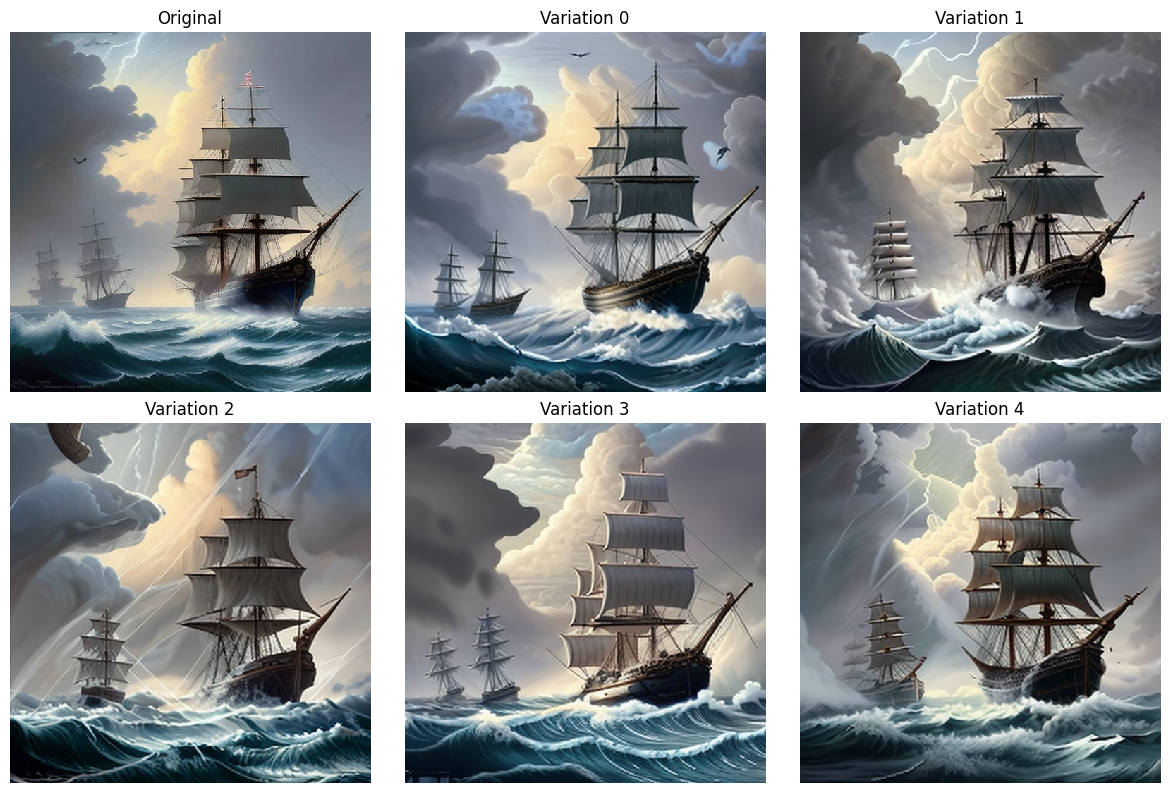

In [15]:
# ==================================================================================================
# Run the denoising loop
image_out = denoising_loop(latents=init_latents, timesteps=timesteps_remaining)

helpers.plot(
    [image_in, *image_out],
    captions=["Original", *[f"Variation {i}" for i in range(len(image_out))]],
)